In [1]:
"""Notebook following Desponds et al's autocorrelation inference procedure on their data as a positive control"""

"Notebook following Desponds et al's autocorrelation inference procedure on their data as a positive control"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gfp_signal
from telegraph import exponential
from scipy.optimize import curve_fit

In [3]:
from astropy.table import Table

In [4]:
import csv
import os

In [5]:
# helpful function for cutting the autocorrelation function into two parts (only want righthand side decay shape)
def findMiddleIndex(input_list):
    middle = float(len(input_list))/2
    if middle % 2 != 0:
        return int(middle - .5)
    else:
        return (int(middle))

In [396]:
# take in anterior cell cycle 13 data ... Pon should be about 0.45
table = Table.read('desponds_data/embryo2-anterior-nc13.csv')

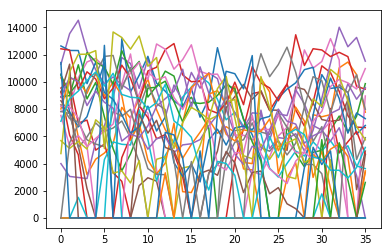

In [397]:
for name in table.colnames:
    plt.plot(table[name])

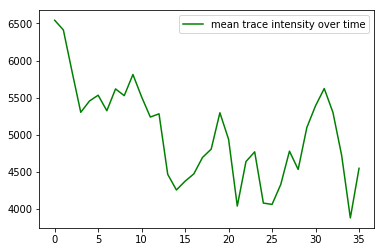

In [398]:
# plot mean intensity over time to define good steady-state window for embryo trace package
traces=[]
for name in table.colnames:
    trace = table[name]
    traces.append(trace)
    
seconds = np.arange(len(trace)) * 6

plt.plot(np.mean(traces, axis=0), color='green', label="mean trace intensity over time")
plt.legend()

In [9]:
# hard-code the autocorrelation of the signal from eq. (12) in Desponds et al
def autocorrelateSignal(trace):
    # over time-delay r
    auto_fn = []
    for r in range(len(trace)):
        sm1 = 0
        for i in range(len(trace)):
            for j in range(len(trace)):
                sm1 += trace[i]*trace[j]
        sm2 = 0.
        for k in range(len(trace)):
            #print(type(k))
            sm2 += (k^2)
        
        norm = ((len(trace)-float(r)) / len(trace)) * sm2
        auto_fn.append(sm1 / norm)
        return np.asarray(auto_fn)

In [816]:
start_index = 5
stop_index = 33

In [869]:
def tracePackageAutocorrelation(table, start_index, stop_index):
    # compute autocorrelation with long time traces
    autolist = []
    tracelist = []
    tracelist_corr = []
    max_intens = []


    for j in table.colnames:
    # calibrate fluorescence signal: F(t) = I(t) / Io
        max_intens.append(np.max(table[j][start_index:stop_index])) # get maximum fluorescence from each trace in given region

            # DO WE STILL COUNT ZERO SIGNAL CELLS????  --> yes, in fact, since they contribute to the average gene expression
            # for a given region.

    I_o = np.mean(np.asarray(max_intens))   # mean of the maxima of all traces in set
    #print('Io = ', I_o)

    for name in table.colnames:
        trace = table[name][start_index:stop_index]
        
        # calibrate fluorescence signal: F(t) = I(t) / Io        
        calibrated_trace = trace / I_o   

        # subtract out mean signal of each trace to prevent nucleus-nucleus variability
        corrected_trace = calibrated_trace - np.nanmean(calibrated_trace)
        
        # check for weird zero traces and fill their autocorrelations with nans
        colsum = np.sum(trace)    

        if (colsum == 0):                                      # don't plot the zero signal traces
            auto_norm = np.ones(len(trace)) * np.nan         # set zero signal cells to nan to be ignored

        else: 
            auto = np.correlate(corrected_trace, corrected_trace, 'full')
            #auto = autocorrelateSignal(corrected_trace)
            auto = auto[np.argmax(auto):]     # take half of the autocorrelation function

            # finally, normalize        
            #auto_norm = auto / auto[0]
            for r in range(len(auto)):
                norm = []
                sm2 = 0.
                for k in range(1,len(corrected_trace)):
                    sm2 += (corrected_trace[k]**2)
                norm.append(((len(corrected_trace)-float(r)) / len(corrected_trace)) * sm2)

            auto_norm = auto / (np.asarray(norm))

        autolist.append(auto_norm / auto_norm[1])   # normalize by second data point
        tracelist.append(calibrated_trace)
        tracelist_corr.append(corrected_trace)
        
    #plt.plot(tracelist[4])
    #print(np.mean(tracelist[3]))

    #plt.ylabel(r'$F(t) =$ $I(t)$ / $I_o$')
    #plt.show()
    
    autoav = np.nanmean(np.asarray(autolist), axis=0)
    autostd = np.nanstd(np.asarray(autolist), axis=0)
    
    return autoav[1:],tracelist_corr,autolist,tracelist,autostd[1:]

In [870]:
autoav,tracelist_corr,autolist,tracelist,autostd = tracePackageAutocorrelation(table, start_index, stop_index)

In [871]:
t = np.arange(len(autoav))

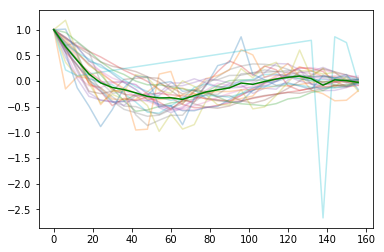

27


In [872]:
autoarr = np.asarray(autoav)

for i in autolist:
    plt.plot(t*6,i[1:], alpha=0.3)

autocov = np.nanvar(autoarr, axis=0)
plt.plot(t*6, autoav, color = 'g', label = "average autocorrelation of trace data \n anterior cell cycle 13")
#plt.errorbar(x=t*6, y=autoav, yerr=(autostd, autostd), ecolor='b', alpha=0.4, label = r'desponds data $\sigma$ standard error')  
#plt.legend(loc='best')
plt.show()

print(len(autoav))

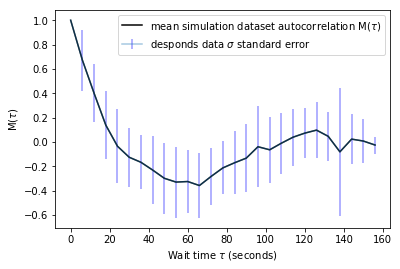

In [873]:
tau = np.arange(len(autoav))   # tau array to plot against

plt.errorbar(x=t*6, y=autoav, yerr=(autostd, autostd), ecolor='b', alpha=0.4, label = r'desponds data $\sigma$ standard error')  

# show the mean of our original dataset in red
plt.plot(t*6, autoav, color='k', label = r'mean simulation dataset autocorrelation M($\tau$)')
plt.legend()
plt.xlabel(r'Wait time $\tau$ (seconds)')
plt.ylabel(r'M($\tau$)')
plt.show()


In [417]:
# STEP TWO: Fit for value of Pon

In [418]:
# load in Desponds et al's loop function
import scipy.io as spio

loopFn = spio.loadmat('standalone/therightL.mat')

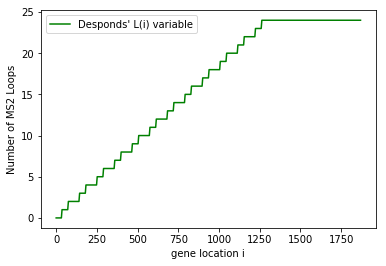

In [419]:
"""Parameters for Li model
ms: variable describing the number of binding sites on nascent mRNA
    ms[i] is the exact number of binding sites available when polII is 
    at the exact location i along the gene
Li: the number of binding sites on nascent mRNA given a BINNED position of polII i along gene"""
obs_time = 6  # seconds
tPol=6;       # RNAP loading time, corresponds to 1 polII every observation
ke=25;        # Elongation rate
sizePol = tPol * ke
variable = loopFn['ms']
ms = variable[0] 

plt.plot(ms, color='green', label = 'Desponds\' L(i) variable')
plt.xlabel('gene location i')
plt.ylabel('Number of MS2 Loops')
plt.legend(loc='best')

In [420]:
"""Now, compute the binned loop Li function"""
Li_fn = []
for i in range(len(ms)//sizePol):    
    Li_fn.append(np.sum(ms[(sizePol*(i-1)+1) : (sizePol*i)]) / sizePol)
    
#for i in range(len(loopfn)//sizePol):
if (i < len(ms) // sizePol):
    print(i)
    Li_fn[i] = np.sum(ms[(sizePol*(i)+1):-1]) / sizePol

11


In [421]:
np.sum(Li_fn) / 150

1.1357777777777778

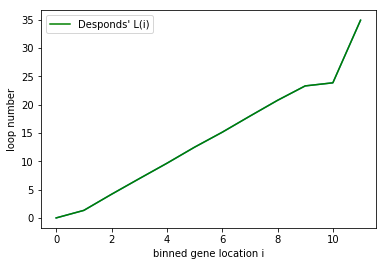

In [422]:
plt.plot(np.asarray(Li_fn))
plt.plot(Li_fn, label = 'Desponds\' L(i)', color='g')
plt.xlabel('binned gene location i')
plt.ylabel('loop number')
plt.legend(loc='best')

In [423]:
len(Li_fn)

12

In [424]:
""" create the array of MS2 loops, L, as a function of position, i
    ***NOTE*** in Desponds et al: "Li" ~should really be written L(i) 
    (adapted from Desponds et al Matlab code) """
import scipy.io as spio
def loopfn(despondsfile, tPol, k_elong, sizePol):
    # load in Desponds et al's loop function
    loopFn = spio.loadmat(despondsfile)
    
    ms = loopFn['ms']
    ms = ms[0]              # stupid matLab puts an array inside an array
    
    
    # make the L(i) function (array of values)
    Li_fn = []
    for i in range(len(ms)//sizePol):    
        Li_fn.append(np.sum(ms[(sizePol*(i-1)+1) : (sizePol*i)]) / sizePol)
    
    if (i < len(ms) // sizePol):
        Li_fn[i] = np.sum(ms[(sizePol*(i)+1):-1]) / sizePol
        
    return Li_fn

In [425]:
def getAverageFlors(tracelist):
    # compute average fluorescence for each raw simulated trace
    avg_flors = []
    for i in tracelist:
        avg_flors.append(np.mean(i))   # stack in an array
    return np.asarray(avg_flors)


In [426]:
avg_flors = getAverageFlors(tracelist)

(array([6., 1., 1., 3., 4., 4., 6., 5., 0., 1.]),
 array([0.        , 0.12061304, 0.24122607, 0.36183911, 0.48245214,
        0.60306518, 0.72367821, 0.84429125, 0.96490428, 1.08551732,
        1.20613035]),
 <a list of 10 Patch objects>)

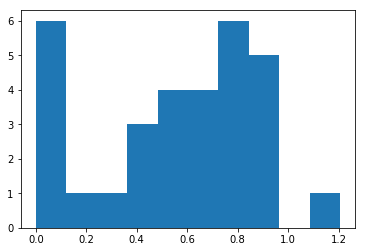

In [427]:
plt.hist(avg_flors)

In [441]:
# fit for pon in a SIMPLE way
def fitPon(tPol, k_elong, tracelist):
    despondsfile = 'standalone/therightL.mat'
    tPol=6;                 # RNAP loading time
    k_elong=25;             # Elongation rate
    sizePol = tPol * k_elong     # Footprint, in basepairs, of polII

    loops = loopfn(despondsfile, tPol, k_elong, sizePol)       # pull in loop function    
    avg_flors = getAverageFlors(tracelist)

    pon = np.mean(avg_flors) / np.sum(loops) * 150
    pon_var = np.std(avg_flors)**2

    return pon,pon_var

In [821]:
tPol=6;                      # RNAP loading time
k_elong=25;                  # Elongation rate
sizePol = tPol * k_elong     # Footprint, in basepairs, of polII

p_on,pon_var = fitPon(tPol, k_elong, tracelist)
print('pon          = ', p_on, '\npon variance = ', pon_var)

pon          =  0.45367421599495905 
pon variance =  0.08304231995663691


In [73]:
# define our average fluorescence function according to Desponds et al's analytic model such that we can fit for p_on
# P_on = <Fluorescence> / sum(loop function)
def avg_flr_fn(average_fluorescence, p_on):
        
    # define parameters for Desponds Pon fitting
    despondsfile = 'standalone/therightL.mat'
    tPol=6;                 # RNAP loading time
    k_elong=25;             # Elongation rate
    sizePol = tPol * k_elong     # Footprint, in basepairs, of polII
        
    loops = loopfn(despondsfile, tPol, k_elong, sizePol)       # pull in loop function    
    average_fluorescence = np.asarray(average_fluorescence)    # make into array
    
    # Divide by the FOOTPRINT in bp of one polII molecule.
    # This ensures that we are in units of number (loops/(polII bin)) * (1/150 (bp/(polII bin))                                                       # final units: loops / bp
    return p_on * np.sum(loops) / sizePol                    

In [74]:
# Calculate the mean v_avg, and variance v^2_avg of fluorescence signal for autocorrelation normalization factor
# v_avg is the average of the averages of each trace's intensity over the steady-state window. v_avg = mean(avg_fluorescence)
# v^2_avg is the average of the squares of the averages of each trace's intensity. v^2_avg = mean(avg_fluorescence^2)

def normFactor(average_fluorescence):
    avg_flors = np.asarray(average_fluorescence)

    v_avg = np.mean(avg_flors)        # calculate the mean of the flourescence
    
    f_sqs = np.zeros(len(avg_flors))
    for i in range(len(avg_flors)):   # calculate the squares of all of the trace averages
        f_sqs[i] = avg_flors[i]**2  

    v_sq_avg = np.mean(f_sqs)             # calculate the second moments
    
    return v_sq_avg - v_avg**2

In [75]:
normFactor(avg_flors)

0.033157176123414844

In [77]:
# do a multiple linear regression fitting for the constant parameter, Pon.
from scipy.optimize import curve_fit
popt_pon,_ = curve_fit(avg_flr_fn, x, ydata=avg_flors)   # return Pon
print("Average fitted P_on for trace package = " + str(popt_pon[0]))

Average fitted P_on for trace package = 0.6571862067899377


In [1481]:
# now move on to fitting the autocorrelation function for the set of traces

In [893]:
""""
Autocorrelation function analysis for Two-State Model using Despond et al's (2016)
parameters:
    tPol: polII loading time
    k_elong:  MS2 GFP loop elongation rate along gene
    tPol:     polII loading time, assumed to load at every observation time
              ***NOTE: this is subject to change since there may exist a blocking time,
              or characteristic "traffic jam" time during polII loading ***
    sizePol:  "Footprint" or size of polII in basepairs, along gene
    
    k_gfp:    gfp loop agglomeration rate such that L(t) = k_gfp*t, L(t) !> maxloops
    maxloops: max number of gfp loops allowed in chain
    
    FITTING FOR:
    ratesum: the inverse characteristic decay timescale for autocorrelation. Tells us how
              similar the signal is to itself and can reveal burst characteristics
              chartime = 1 / (k_on + k_off)
              
    Pon:      Probability that system is in "ON" state.
    k_on:     given as 1/mu for exponential distribution of ON wait times
    k_off:    1/mu for exponential distribution of OFF wait times

    ***NOTE: k_on and k_off decoupled by Pon = k_on / (k_on + k_off)
    """


def autocorr(t, chartime):#, p_on=0.45):  # take in parameters and t (signal data array index in seconds)
    # define all needed parameters #
    despondsfile = 'standalone/therightL.mat'
    stepsize = 6            # time between observations, seconds
    tPol=6;                 # polII loading time
    k_elong=25;             # Elongation rate
    sizePol = tPol * ke     # Footprint, in basepairs, of polII
    
    time = np.arange(len(t)) * stepsize
    
    tracelength = len(t)        # calculate from trace inputs
    
    # get the loop function
    loops = loopfn(despondsfile, tPol, k_elong, sizePol)
    
    # do the Pon fitting (once I've written the function)
    # pon,pon_upper,pon_lower = pon_fit()
    
    # FOR NOW:
    #p_on = fitPon(tracelist)
    #p_on = 0.49
    p_off = 1-p_on
    
    # compute normalization constant
    avg_flors = getAverageFlors(tracelist)
    normfactor = normFactor(avg_flors)

    
    # write analytic autocorrelation function according to Desponds et al:    
    # chartime is defined as k_on + k_off
    
    delta = 1 - chartime    
   
       
    # write a for loop to do the double sums to compute connected correlation:
    
    c_arr = []
    
    for t in range(len(time)):
        sm0 = 0
        for i in range(len(loops)):
            for j in range(len(loops)):
                sm0 += p_on*p_off*(loops[i] * loops[j] * np.exp((delta-1)*np.abs(t - j + i)))
     
        c_arr.append(sm0)
    #plt.plot(c_arr)
           
    connected_corr = np.asarray(c_arr)    # the two-state connected correlation function
    #return connected_corr / np.max(connected_corr)
   
    N = len(time)         # CONSTANT trace length
    
    # Add in the finite trace correction for the Ornstein-Uhlenbeck process    
    # perform the summations
    
    # initialize corrected lists
    corrected_full = []
    Co = connected_corr[0]    # initial condition of connected correlation function
        
    # Now we're going to correct EVERY data point in the connected autocorrelation function
    for r in range(len(connected_corr)):
    
        sm1 = 0    
        for k in range(1,N):
            sm1 += 2*(N - k)*connected_corr[k]
    
        sm2 = 0   
        for j in range(1,r):
            sm2 += 2*(r-j)*connected_corr[j]

        sm3 = 0
        for m in range(1,N):
            sm3 += connected_corr[m] * (np.min(np.asarray([m+r, N])) - np.max(np.asarray([r, m])))
    
        # full correction
        corrected_full.append((connected_corr[r] + 
                                    (1/N) *((1/N) - (2./(N-r))) * (N*Co + sm1)) + ((2/(N*(N-r))) * (r*Co + sm2 + sm3)))
        
    
    normed = (normfactor)*np.asarray(corrected_full)
    
    return (normed / normed[0]) # / normed[0])

In [894]:
# get our data's average autocorrelation function
dat = autoav   
t = np.arange(len(dat)) * 6

In [760]:
plt.plot(autocorr(t,33, 0.47))

TypeError: autocorr() takes 2 positional arguments but 3 were given

In [823]:
autoav_norm = autoav / np.max(autoav)
normlist = []
for i in autolist:
    normlist.append(i / np.max(i))

autostd_norm = np.nanstd(normlist, axis=0)[1:]


In [895]:
from scipy.optimize import curve_fit
popt,pcov = curve_fit(autocorr, t, autoav)

print("k_on + k_off              = ", popt[0], 's^-1')
print("t_polII_block             =  6 seconds")
print("characteristic timescale  = ", 1/(popt[0]), 'time units')
print("covariance                = ", pcov[0][0])

k_on + k_off              =  20.907185484245986 s^-1
t_polII_block             =  6 seconds
characteristic timescale  =  0.04783044569789279 time units
covariance                =  97366051249576.94


In [896]:
autoav

array([ 1.        ,  0.6725413 ,  0.40001615,  0.13814761, -0.03587704,
       -0.12637377, -0.16752777, -0.23128641, -0.29926961, -0.33047364,
       -0.32591251, -0.35888078, -0.28381283, -0.21393227, -0.17176954,
       -0.1336376 , -0.03984184, -0.06502006, -0.01077602,  0.03867696,
        0.07196865,  0.09672006,  0.0457742 , -0.08180758,  0.02264892,
        0.00693646, -0.02586896])

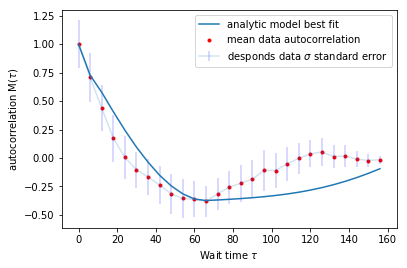

In [897]:
plt.plot(t, autocorr(t, popt[0]), label='analytic model best fit')
#for i in autolist[1:]:
    #plt.plot(t, i[1:], color='b', alpha=0.1)

plt.scatter(t,autoav_norm, marker='.', color='r', label = 'mean data autocorrelation')   # show the mean of our original dataset in red
#plt.plot(np.arange(len(autoav)),dat, color='r', label = 'mean data autocorrelation')   # show the mean of our original dataset in red
plt.errorbar(x=t, y=autoav_norm, yerr=(autostd_norm, autostd_norm), ecolor='b', alpha=0.2, label = r'desponds data $\sigma$ standard error')  
plt.legend()
plt.xlabel(r'Wait time $\tau$')
plt.ylabel(r'autocorrelation M($\tau$)')
plt.show()

In [1361]:
# Do a more packaged fitting with written functions. Bayesian fitting, assuming Gaussian error distributed 
# about each autocorrelated point, conservatively approximated by the standard error of autocorrelation

In [877]:
""" For this fit, we'll use the square of the standard error of the set of trace 
autocorrelations as our (conservative) inverse-variance. For this, we take the standard deviation
between each trace's data and the mean at each autocorrelated time point . """
y_err = autostd   # our error (sigma) in y-data
y = autoav        # our y-data that we wish to fit
t = t             # time delay x-axis of autocorrelation

tPol=6;                      # RNAP loading time
k_elong=25;                  # Elongation rate
sizePol = tPol * k_elong     # Footprint, in basepairs, of polII

p_on,pon_var = fitPon(tPol, k_elong, tracelist)

# pars = [chartime, p_on], where p_on is held fixed.

In [878]:
class AutoCorrelationModel(object):

    def __init__(self, t, y, y_err, p_on):
        """
        What we're going to do is put all of the computation, from traces to 
        average autocorrelation, into one object for fitting
        """
        self.t = np.asarray(t)
        self.y = np.asarray(y)
        self.y_err = np.asarray(y_err)
        self.p_on = p_on
        
    def ln_likelihood(self, chartime):
        N = len(self.y)     # number of data points
        dy = self.y - autocorr(self.t, chartime, p_on) # difference in analytic model and data
        ivar = 1 / self.y_err**2                       # inverse-variance dependent on the sigmas of 
                                                       # trace autocorrelations
        return -0.5 * (N*np.log(2*np.pi) + np.sum(2*np.log(self.y_err)) + np.sum(dy**2 * ivar))
        
        
    def ln_prior(self, chartime):
        chartime = chartime    # might add more parameters later
        ln_prior_val = 0.      # to be added to 
        
        if chartime < 0 or chartime > 100.: 
            return -np.inf     # constrain chartime in sampling
        else:
            ln_prior_val += np.log(1E-2)  # normalization of log(1/100)
            
        return ln_prior_val
    
    def ln_posterior(self, chartime):
        """
        log of posterior pdf is just the sum of ln(likelihood) + ln(prior)
        """
        lnp = self.ln_prior(chartime)
        if np.isinf(lnp):  # stop if prior is infinite
            return lnp
        
        lnL = self.ln_likelihood(chartime)
        lnprob = lnp + lnL
        
        if np.isnan(lnprob):
            return -np.inf
        
        return lnprob
    
    def __call__(self, chartime):
        return self.ln_posterior(chartime)
        

In [879]:
automodel = AutoCorrelationModel(t, y, y_err, p_on=p_on)

In [880]:
# Now implement Markov Chain Monte Carlo sampling
def sample_proposal(*sigmas):
    return np.random.normal(0., sigmas)

def run_metropolis_hastings(p0, n_steps, model, proposal_sigmas):
    """
    Run a Metropolis-Hastings MCMC sampler to generate samples from the input
    log-posterior function, starting from some initial parameter vector.
    
    Parameters
    ----------
    p0 : iterable
        Initial parameter vector.
    n_steps : int
        Number of steps to run the sampler for.
    model : StraightLineModel instance (or subclass)
        A callable object that takes a parameter vector and computes 
        the log of the posterior pdf.
    proposal_sigmas : list, array
        A list of standard-deviations passed to the sample_proposal 
        function. These are like STEP SIZES in each of the parameters.
    """
    
    p0 = np.array(p0)
    if len(proposal_sigmas) != len(p0):
        raise ValueError("Proposal distribution should have same shape as parameter vector.")

        
    # the objects we'll fill and return:
    chain = np.zeros((n_steps, len(p0))) # parameter values at each step
    ln_probs = np.zeros(n_steps) # log-probability values at each step
    
    # we'll keep track of how many steps we accept to compute the acceptance fraction                        
    n_accept = 0 
    
    # evaluate the log-posterior at the initial position and store starting position in chain
    ln_probs[0] = model(p0)
    chain[0] = p0
    
    # loop through the number of steps requested and run MCMC
    for i in range(1,n_steps):
        # proposed new parameters
        step = sample_proposal(*proposal_sigmas)
        new_p = chain[i-1] + step
        
        # compute log-posterior at new parameter values
        new_ln_prob = model(new_p)
        
        # log of the ratio of the new log-posterior to the previous log-posterior value
        ln_prob_ratio = new_ln_prob - ln_probs[i-1]
        
        if (ln_prob_ratio > 0) or (ln_prob_ratio > np.log(np.random.uniform())):
            chain[i] = new_p
            ln_probs[i] = new_ln_prob
            n_accept += 1
            
        else:
            chain[i] = chain[i-1]
            ln_probs[i] = ln_probs[i-1]
    
    acc_frac = n_accept / n_steps
    return chain, ln_probs, acc_frac
    

In [887]:
# Now we'll choose a starting point, p0, for our chartime
p0 = [20]

chain,_,acc_frac = run_metropolis_hastings(p0, n_steps=815, model=automodel, 
                                           proposal_sigmas=[0.05])
print("Acceptance fraction: {:.1%}".format(acc_frac))


C:\Users\tmakinen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
C:\Users\tmakinen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
C:\Users\tmakinen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply
C:\Users\tmakinen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars


Acceptance fraction: 0.0%


No handles with labels found to put in legend.


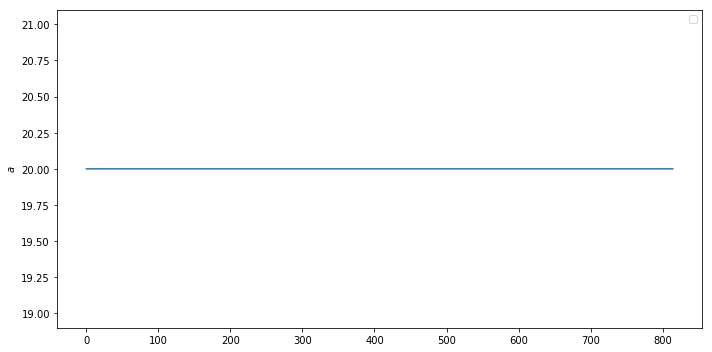

In [888]:
fig,ax = plt.subplots(len(p0), 1, figsize=(10,5), sharex=True)

for i in range(len(p0)):
    ax.plot(chain[:,i], marker='', drawstyle='steps')

ax.legend(loc='best')
ax.set_ylabel('$a$')

fig.tight_layout()

In [889]:
chain.shape

(815, 1)

In [890]:
good_samples = chain[20::8]
good_samples.shape

(100, 1)

In [891]:
low,med,hi = np.percentile(good_samples, [16, 50, 84], axis=0)
upper, lower = hi-med, med-low

disp_str = ""
for i,name in enumerate(['chartime']):
    fmt_str = '{name}={val:.2f}^{{+{plus:.2f}}}_{{-{minus:.2f}}}'
    disp_str += fmt_str.format(name=name, val=med[i], plus=upper[i], minus=lower[i])
    disp_str += r'\quad '
    
disp_str = "${}$".format(disp_str)
display.Latex(data=disp_str)

<IPython.core.display.Latex object>

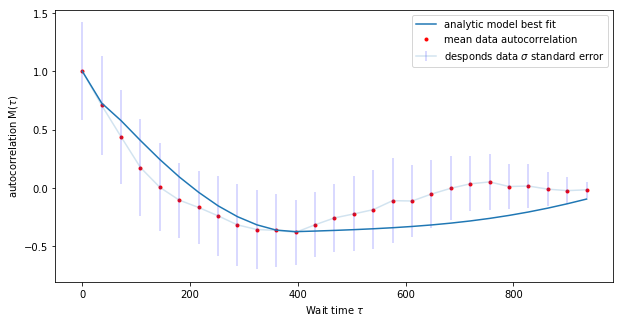

In [892]:
fig,ax = plt.subplots(len(p0), 1, figsize=(10,5), sharex=True)

ax.plot(t*6, autocorr(t,chartime=med, p_on=p_on), label='analytic model best fit')
#for i in autolist[1:]:
    #plt.plot(t, i[1:], color='b', alpha=0.1)

ax.scatter(t*6,autoav_norm, marker='.', color='r', label = 'mean data autocorrelation')   # show the mean of our original dataset in red
#plt.plot(np.arange(len(autoav)),dat, color='r', label = 'mean data autocorrelation')   # show the mean of our original dataset in red
ax.errorbar(x=t*6, y=autoav_norm, yerr=(autostd_norm*2, autostd_norm*2), ecolor='b', alpha=0.2, label = r'desponds data $\sigma$ standard error')  
plt.legend()
ax.set_xlabel(r'Wait time $\tau$')
ax.set_ylabel(r'autocorrelation M($\tau$)')
plt.show()